# Synsets, wordnet and Yelp reviews

Here we use the `en_core_web_sm` spacy language model. If you haven't already, install it by running `python -m spacy download en_core_web_sm` in a terminal.

Also, run <code>nltk.download('sentiwordnet')</code> if you never ran it.

In [1]:
import sys
import json
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from tqdm import tqdm_notebook
from nltk.corpus import sentiwordnet as swn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

`ConfusionMatrixDisplay` requires `scikit-learn`'s version to be $>0.20$. You can check if by running `!conda list scikit-learn` in a cell below here. Otherwise, you need to update it by running `conda update scikit-learn` in a terminal. Be aware that if you have `textacy` version $0.8$ also installed in the same environment, then scikit-learn will not update.

**IF YOU DO NOT HAVE THIS MODULE AND YOU DON'T WANT TO INSTALL IT, THEN DO NOT RUN THE CELL BELOW!**. You'll just see the confusion matrix in textual format and not graphical.

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay

## Pre-processing class

In [3]:
class SpacyTokenizer(object): 
    def __init__(self, model='en_core_web_sm', lemma=True, pos_filter=None):
        self.pos = pos_filter
        self.lemma = lemma
        self.nlp = spacy.load(model)
    
    def tokenize(self, text):
        tokens = []
        for token in self.nlp(text):
            if self.lemma:
                tk = token.lemma_
            else:
                tk = token.text
            if self.pos is None or token.pos_ in self.pos:
                tokens.append((tk, token.pos_))
            else:
                pass
        return tokens

## Scoring class

In [4]:
class SentiWn(object):    
    def __init__(self, strategy='sum', use_pos=False):
        self.strategy = strategy
        self.pos = use_pos
        self.pos_map = {
            'NOUN': 'n',
            'ADJ': 'a',
            'VERB': 'v',
            'ADV': 'r'
        }
        self.strategy_map = {
            'sum': self._simple_sum,
            'weighted_sum': self.weighted_sum,
            'average_score': self.average_score, 
            'weighted_average': self.weighted_average}
    
    # Simplest solution.
    # Double-sum: we sum the score for each synset for each word
    def _simple_sum(self, text):
        s = np.zeros(3)
        for token, pos in text:
            if self.pos:
                try:
                    synsets = list(swn.senti_synsets(token, self.pos_map[pos]))
                except KeyError:
                    pass
            else:
                synsets = list(swn.senti_synsets(token))
            for syn in synsets:
                p, n, o = syn.pos_score(), syn.neg_score(), syn.obj_score()
                s[0] += p
                s[1] += n
                s[2] += o
        return s
    
    # We weight the scores considering how many synsets each word has:
    # the more syns a word has, the lower its importance.
    def weighted_sum(self, text):
        s = np.zeros(3)
        all_s = [] 
        if self.pos:
            all_s = [list(swn.senti_synsets(token, self.pos_map[pos])) for token, pos in text]
        else:
            all_s = [list(swn.senti_synsets(token)) for token, pos in text]
        
        for i, (token, pos) in enumerate(text):
            try:
                synsets = all_s[i]
                sidf = np.log(max([len(l) for l in all_s]) / len(synsets))
                for syn in synsets:
                    p, n, o = syn.pos_score(), syn.neg_score(), syn.obj_score()
                    s[0] += p * sidf
                    s[1] += n * sidf
                    s[2] += o * sidf # this is neutral
            except ZeroDivisionError:
                pass
        return s
    
    # We just average each score, so that we have an averaged positive, average negative
    # and average neutral
    def average_score(self, text):
        counter = 0
        s = np.zeros(3)
        for token, pos in text:
            if self.pos:
                try:
                    synsets = list(swn.senti_synsets(token, self.pos_map[pos]))
                except KeyError:
                    pass
            else:
                synsets = list(swn.senti_synsets(token))
            for syn in synsets:
                p, n, o = syn.pos_score(), syn.neg_score(), syn.obj_score()
                s[0] += p
                s[1] += n
                s[2] += o
                
                counter += 1
            
        s[0] = s[0]/counter
        s[1] = s[1]/counter
        s[2] = s[2]/counter
        
        return s
    
    # We average the weighted sum
    def weighted_average(self, text):
        s = np.zeros(3)
        all_s = [] 
        if self.pos:
            all_s = [list(swn.senti_synsets(token, self.pos_map[pos])) for token, pos in text]
        else:
            all_s = [list(swn.senti_synsets(token)) for token, pos in text]
        
        counter = 0
        
        for i, (token, pos) in enumerate(text):
            try:
                synsets = all_s[i]
                sidf = np.log(max([len(l) for l in all_s]) / len(synsets))
                for syn in synsets:
                    p, n, o = syn.pos_score(), syn.neg_score(), syn.obj_score()
                    s[0] += p * sidf
                    s[1] += n * sidf
                    s[2] += o * sidf # this is neutral
                    
                    counter += sidf
            except ZeroDivisionError:
                pass
        
        s[0] = s[0]/counter
        s[1] = s[1]/counter
        s[2] = s[2]/counter
        
        return s
    
    def predict(self, docs):
        try:
            score_function = self.strategy_map[self.strategy]
        except KeyError:
            raise Exception('{} strategy not yet available'.format(self.strategy))

        self.doc_scores = np.array([score_function(doc) for doc in docs])
        
        # we scale data bc the "objective" (=neutral) scores are always higher than pos and neg scores. Thus, if
        # we just took the max, then every document would have been considered neutral
        self.S = MinMaxScaler().fit_transform(self.doc_scores)
        
        # returns the index of the column with the highest val for each row
        # Thus: 0 = positive (first column), 1 = negative (second column), 2 = neutral
        pred = self.S.argmax(axis=1)
        y_pred = [1 if p == 0 else -1 if p == 1 else 0 for i, p in enumerate(pred)]
        
        return y_pred
    
    def custom_plots(self, y_true):
        fig, ax = plt.subplots(figsize=(14, 4), nrows=2, ncols=2)
        ax[0,0].boxplot(self.doc_scores)
        ax[0,1].scatter(self.doc_scores[:,0], self.doc_scores[:,1], alpha=0.4, c=y_true)
        ax[1,0].boxplot(self.S)
        ax[1,1].scatter(self.S[:,0], self.S[:,1], alpha=0.4, c=y_true)
        return plt

## Pre-processing

In [ ]:
yelp = pd.read_csv('data/yelp_example_1_small.tsv', sep='\t')

In [ ]:
tokenizer = SpacyTokenizer(lemma=True, pos_filter=['NOUN', 'ADV', 'ADJ', 'VERB'])

In [ ]:
tokenizer.tokenize(yelp.iloc[0].content)

In [ ]:
docs, titles, scores = [], [], []
data = tqdm_notebook(list(yelp.iterrows()))
for i, row in data:
    tokens = tokenizer.tokenize(row.content)
    docs.append(tokens)
    titles.append(row.business)
    scores.append(row.score)

In [ ]:
with open('data/yelp_example_1.json', 'w') as out:
    json.dump({'docs': docs, 'titles': titles, 'scores': scores}, out)

## Wordnet and synsets examples

In [5]:
synsets = list(swn.senti_synsets('happy'))

for syn in synsets:
    print(syn)

<happy.a.01: PosScore=0.875 NegScore=0.0>
<felicitous.s.02: PosScore=0.75 NegScore=0.0>
<glad.s.02: PosScore=0.5 NegScore=0.0>
<happy.s.04: PosScore=0.125 NegScore=0.0>


In [6]:
for syn in synsets:
    print(syn.synset.definition())

enjoying or showing or marked by joy or pleasure
marked by good fortune
eagerly disposed to act or to be of service
well expressed and to the point


In [7]:
synsets = list(swn.senti_synsets('play', 'v'))

for syn in synsets:
    print(syn)

<play.v.01: PosScore=0.0 NegScore=0.0>
<play.v.02: PosScore=0.0 NegScore=0.0>
<play.v.03: PosScore=0.25 NegScore=0.0>
<act.v.03: PosScore=0.0 NegScore=0.0>
<play.v.05: PosScore=0.0 NegScore=0.0>
<play.v.06: PosScore=0.0 NegScore=0.0>
<play.v.07: PosScore=0.25 NegScore=0.0>
<act.v.05: PosScore=0.0 NegScore=0.0>
<play.v.09: PosScore=0.0 NegScore=0.0>
<play.v.10: PosScore=0.0 NegScore=0.0>
<play.v.11: PosScore=0.0 NegScore=0.0>
<play.v.12: PosScore=0.0 NegScore=0.0>
<play.v.13: PosScore=0.0 NegScore=0.0>
<play.v.14: PosScore=0.0 NegScore=0.0>
<play.v.15: PosScore=0.0 NegScore=0.0>
<play.v.16: PosScore=0.0 NegScore=0.0>
<play.v.17: PosScore=0.0 NegScore=0.0>
<play.v.18: PosScore=0.0 NegScore=0.0>
<toy.v.02: PosScore=0.25 NegScore=0.0>
<play.v.20: PosScore=0.5 NegScore=0.0>
<dally.v.04: PosScore=0.0 NegScore=0.25>
<play.v.22: PosScore=0.125 NegScore=0.0>
<dally.v.01: PosScore=0.0 NegScore=0.0>
<play.v.24: PosScore=0.0 NegScore=0.0>
<act.v.10: PosScore=0.0 NegScore=0.0>
<play.v.26: PosScore=

In [8]:
for syn in synsets:
    print(syn.synset.definition())

participate in games or sport
act or have an effect in a specified way or with a specific effect or outcome
play on an instrument
play a role or part
be at play; be engaged in playful activity; amuse oneself in a way characteristic of children
replay (as a melody)
perform music on (a musical instrument)
pretend to have certain qualities or state of mind
move or seem to move quickly, lightly, or irregularly
bet or wager (money)
engage in recreational activities rather than work; occupy oneself in a diversion
pretend to be somebody in the framework of a game or playful activity
emit recorded sound
perform on a certain location
put (a card or piece) into play during a game, or act strategically as if in a card game
engage in an activity as if it were a game rather than take it seriously
behave in a certain way
cause to emit recorded audio or video
manipulate manually or in one's mind or imagination
use to one's advantage
consider not very seriously
be received or accepted or interpreted i

## Application on the Yelp reviews

In [9]:
with open('data/yelp_example_1.json', 'r') as infile:
    data = json.load(infile)
    
docs = data['docs']
titles = data['titles']
scores = data['scores']

In [10]:
''' The Num argument indicates the value of the review (i.e: 3 stars).
If the review has more the num stars, then it is postive (=1); otherwise, negative (=-1). 0 for neutral.
We can also get only positive and negative, without neutral, by setting the use_neutral argument to False
'''
def get_true_label_from_score(num, use_neutral = True):
    if use_neutral:
        return [1 if score > num else -1 if score < num else 0 for i, score in enumerate(scores)]
    else:
        return [1 if score >= num else -1 for i, score in enumerate(scores)]

In [11]:
y_true = get_true_label_from_score(3)

### 01. Simple sum

In [12]:
wn = SentiWn(strategy='sum', use_pos=True)

In [13]:
y_pred = wn.predict(docs)

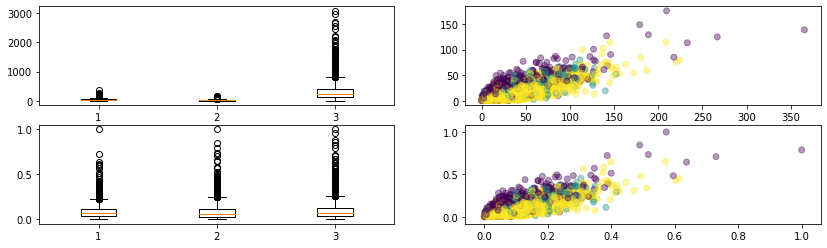

In [14]:
wn.custom_plots(y_true).show()

In [15]:
def print_report_plot_cf(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print(report)
    
    if 'sklearn.metrics._plot.confusion_matrix' in sys.modules:
        fig, ax = plt.subplots(figsize=(8, 8))
        d = ConfusionMatrixDisplay(cm, [-1, 0, 1])
        d.plot(cmap=plt.cm.Blues, ax=ax, values_format='10.0f')
        plt.show()
    else:
        print(cm)

              precision    recall  f1-score   support

          -1       0.35      0.39      0.37      1016
           0       0.13      0.43      0.20       642
           1       0.82      0.42      0.56      3342

    accuracy                           0.42      5000
   macro avg       0.43      0.41      0.37      5000
weighted avg       0.63      0.42      0.47      5000



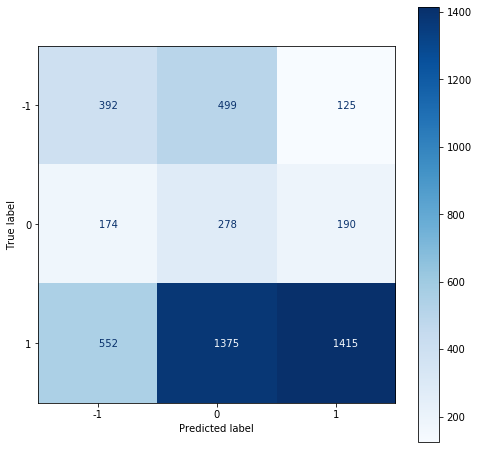

In [16]:
print_report_plot_cf(y_true, y_pred)

### 02. Weighted sum

In [17]:
wn_w = SentiWn(strategy='weighted_sum')
y_w_pred = wn_w.predict(docs)

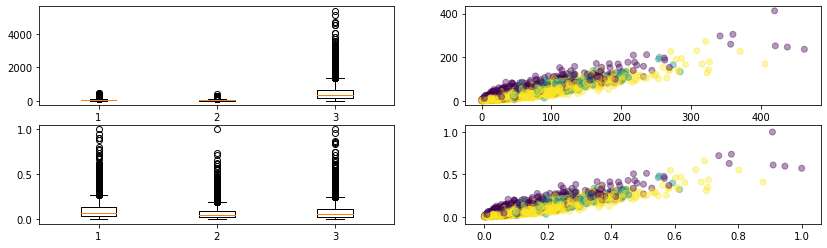

In [18]:
wn_w.custom_plots(y_true).show()

              precision    recall  f1-score   support

          -1       0.61      0.28      0.38      1016
           0       0.14      0.27      0.19       642
           1       0.78      0.77      0.77      3342

    accuracy                           0.60      5000
   macro avg       0.51      0.44      0.45      5000
weighted avg       0.66      0.60      0.62      5000



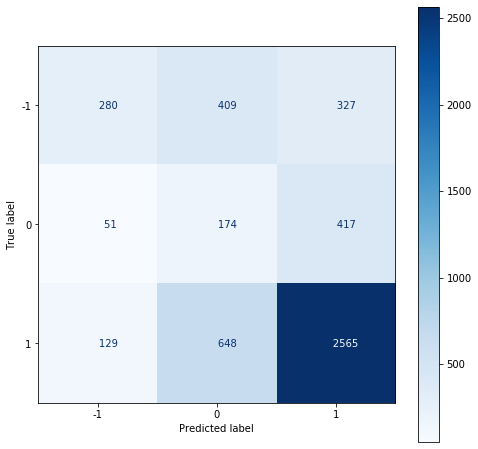

In [19]:
print_report_plot_cf(y_true, y_w_pred)

### 03. Average score

In [20]:
wn_a = SentiWn(strategy='average_score')
y_a_pred = wn_a.predict(docs)

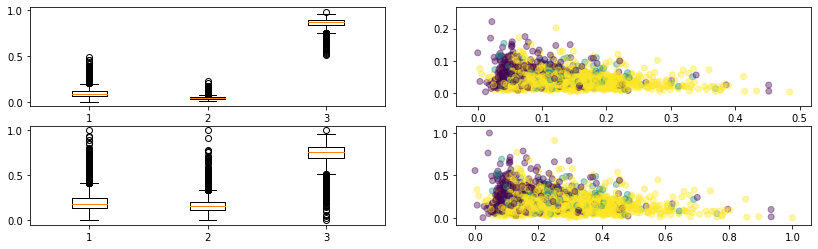

In [21]:
wn_a.custom_plots(y_true).show()

              precision    recall  f1-score   support

          -1       0.56      0.01      0.03      1016
           0       0.13      0.98      0.23       642
           1       0.86      0.04      0.07      3342

    accuracy                           0.15      5000
   macro avg       0.52      0.34      0.11      5000
weighted avg       0.70      0.15      0.08      5000



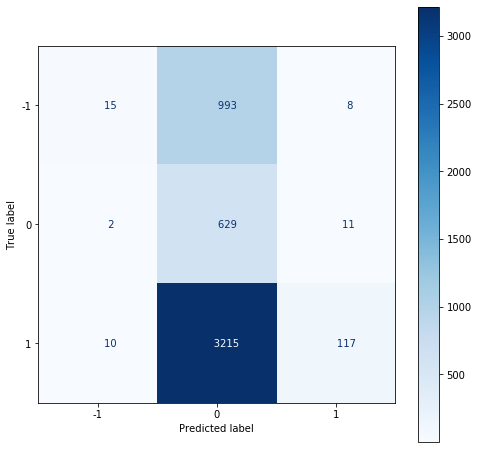

In [22]:
print_report_plot_cf(y_true, y_a_pred)

### 04. Weighted average

In [23]:
wn_wa = SentiWn(strategy='weighted_average')
y_wa_pred = wn_wa.predict(docs)

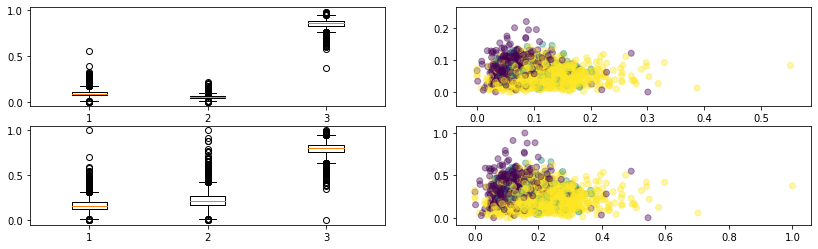

In [24]:
wn_wa.custom_plots(y_true).show()

              precision    recall  f1-score   support

          -1       0.61      0.01      0.02      1016
           0       0.13      1.00      0.23       642
           1       0.89      0.00      0.00      3342

    accuracy                           0.13      5000
   macro avg       0.54      0.34      0.08      5000
weighted avg       0.73      0.13      0.04      5000



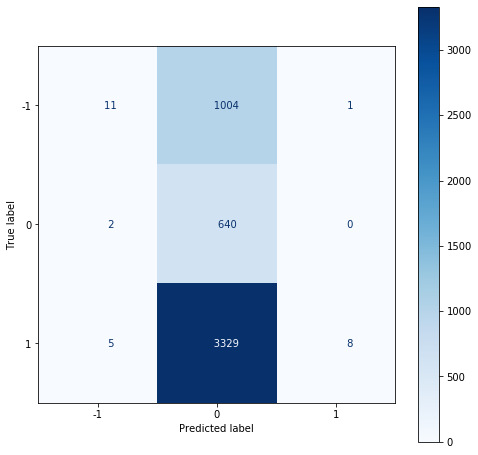

In [25]:
print_report_plot_cf(y_true, y_wa_pred)